<a href="https://colab.research.google.com/github/okim1227/ENPH353_Parking_Robot/blob/main/ENPH353_License_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np 
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from google.colab.patches import cv2_imshow

# **Making Wrangled Sample Plates** (Run Once)

**Resized, rotated**





In [ ]:
# Run this command only once:

# makes the output folder /content/plate_blurred/
path = "/content/drive/MyDrive/ENPH353/"
!mkdir /content/drive/MyDrive/ENPH353/plate_blurred

mkdir: cannot create directory ‘/content/drive/MyDrive/ENPH353/plate_blurred’: No such file or directory


In [ ]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
1
2
3
4
1
2
3
4
1
2
3
44

Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 52.4MB/s]


44

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/ENPH353/"

NUMBER_OF_PLATES = 10

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)
    
    img = blank_plate
    
    #print('Original Dimensions : ',img.shape)
    
    # downsize img
    downsize_scale_percent = 10 # percent of original size
    d_width = int(img.shape[1] * downsize_scale_percent / 100)
    d_height = int(img.shape[0] * downsize_scale_percent / 100)
    down_dim = (d_width, d_height)

    downsized = cv2.resize(img, down_dim, interpolation = cv2.INTER_AREA)
    #print('Downsized Dimensions : ',downsized.shape)

    # upsize img
    upsize_scale_percent = 1000 # percent of original size
    u_width = int(downsized.shape[1] * upsize_scale_percent / 100)
    u_height = int(downsized.shape[0] * upsize_scale_percent / 100)
    up_dim = (u_width, u_height)
      
    upsized = cv2.resize(downsized, up_dim, interpolation = cv2.INTER_AREA)
    print('Upsized Dimensions : ',upsized.shape)

    # rescale the image to match detected plates
    resized_scale_percent_H = 41/290*100
    resized_scale_percent_W = 175/600*100
    r_width = int(upsized.shape[1] * resized_scale_percent_W / 100)
    r_height = int(upsized.shape[0] * resized_scale_percent_H / 100)
    re_dim = (r_width, r_height)

    resized = cv2.resize(upsized, re_dim, interpolation = cv2.INTER_AREA)
    print('Resized Dimensions : ',resized.shape)

    # turn into binary
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY_INV)
    print('Resized Dimensions : ',binary.shape)
    
    plt.imshow(upsized)
    plt.show()

    plt.imshow(resized)
    plt.show()

    plt.imshow(binary, cmap='gray')
    plt.show()


    # Write license plate to file
    # cv2.imwrite(os.path.join(path + "plate_blurred/", 
    #                         "plate_{}{}.png".format(plate_alpha, plate_num)),
    #                         binary)

In [ ]:
# PATH = "/content/drive/MyDrive/ENPH353/plate_blurred"
# labels_raw = !ls "{PATH}"
# labels = labels_raw[0].split()
# print(labels)



```
# This is formatted as code
```

# **Build Model**


In [ ]:
import math
import numpy as np
import re
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
# You will need to update this path to match the folder in your Google Drive
PATH = "/content/drive/MyDrive/ENPH353/plate_blurred"

In [ ]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

In [ ]:
files = files_in_folder(PATH)

In [ ]:
#crop the images
import cv2

i = 0

for file in files[:]:
  img = cv2.imread(f'{PATH}/{file}')
  crop_img1 = img[0:41, 18:43]
  crop_img2 = img[0:41, 43:68]
  crop_img3 = img[0:41, 103:128]
  crop_img4 = img[0:41, 128:153]
  
  img_1 = "/content/drive/MyDrive/ENPH353/plate_cropped/" + file[6] + "." + str(i) + ".png"
  img_2 = "/content/drive/MyDrive/ENPH353/plate_cropped/" + file[7] + "." + str(i) +".png"
  img_3 = "/content/drive/MyDrive/ENPH353/plate_cropped/" + file[8] + "." + str(i) +".png"
  img_4 = "/content/drive/MyDrive/ENPH353/plate_cropped/" + file[9] + "." + str(i) +".png"

  cv2.imwrite(img_1, crop_img1)
  cv2.imwrite(img_2, crop_img2)
  cv2.imwrite(img_3, crop_img3)
  cv2.imwrite(img_4, crop_img4)

  i = i + 1

  #print(crop_img1.shape)

In [ ]:
def convert_to_one_hot(letter):
  array = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  index = array.index(letter)
  Y= np.eye(36)[index]
  return Y

In [ ]:
#X_dataset= np.array([data[0] for data in imgset[:]])/255


# Load the images and assign label 0 and 1
datas = files_in_folder("/content/drive/MyDrive/ENPH353/plate_cropped/")

imgset = np.array([[np.array(Image.open(f'{"/content/drive/MyDrive/ENPH353/plate_cropped/"}/{file}')), file[0]]
                    for file in datas[:]])

# Shuffle the dataset
np.random.shuffle(imgset)

X_dataset_orig = np.array([data[0] for data in imgset[:]])

cv2_imshow(X_dataset_orig[0])

print(X_dataset_orig.shape)


X_dataset = X_dataset_orig/255
Y_dataset_orig = np.array([[data[1]] for data in imgset])
Y_dataset = np.array([convert_to_one_hot(letter) for letter in Y_dataset_orig])


print(X_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(1454, 41, 25, 3)
(1454, 41, 25, 3)


In [ ]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 1454
Training examples: 1164
Test examples: 290
X shape: (1454, 41, 25, 3)
Y shape: (1454, 36)


interactive(children=(IntSlider(value=10, description='index', max=1454), Output()), _dom_classes=('widget-int…

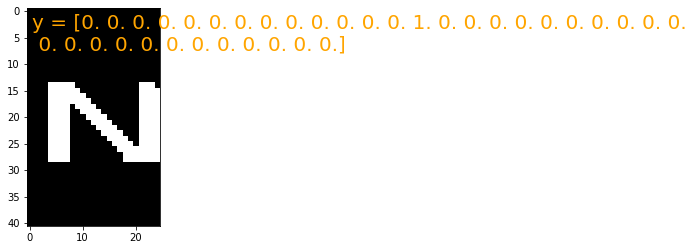

In [ ]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set. 
def displayImage(index):
  plt.imshow(X_dataset[index])
  caption = ("y = " + str(Y_dataset[index]))#str(np.squeeze(Y_dataset_orig[:, index])))
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 20,
           horizontalalignment='left', verticalalignment='top')


interact(displayImage, 
         index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
                                    step=1, value=10))
displayImage(35)

# **Training**

In [ ]:
# Use tensorflow 1.x so it's compatible with ROS Melodic
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
#!pip install h5py==2.10.0 --force-reinstall

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 15.7 MB 38.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.5.3 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.5 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, bu

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend

In [ ]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(41, 25, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(41, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(25, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

In [ ]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 39, 23, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 9, 64)         18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 2, 41)          23657     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 1, 41)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 123)              

In [ ]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [ ]:
reset_weights(conv_model)

In [ ]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=80, 
                              batch_size=16)

ValueError: ignored

In [ ]:
conv_model.save("licence_CNN_model.h5")

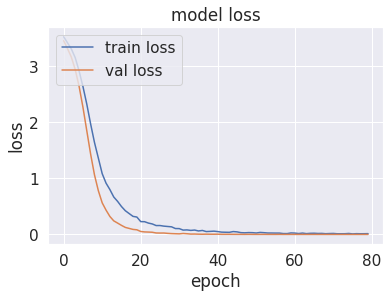

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

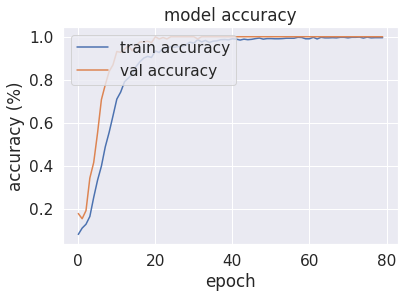

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred=conv_model.predict(X_dataset) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_dataset, axis=1)
cm = confusion_matrix(y_test, y_pred)

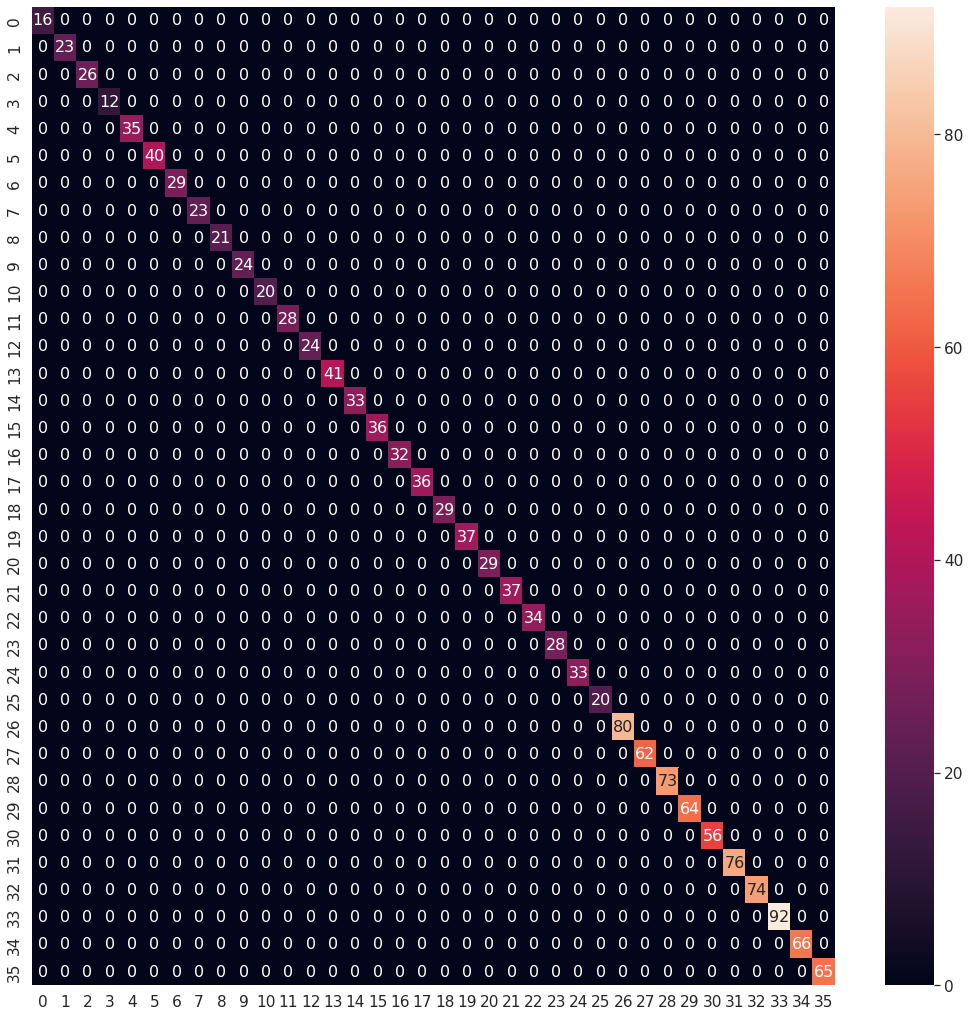

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(36), range(36))
plt.figure(figsize=(18,18))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()